# Farbvergleich in Bildern

Dieses Notebook zeigt zwei Methoden zur Berechnung der Farbähnlichkeit zwischen Bildern:

1. Histogramm-Vergleich im HSV-Farbraum
2. Vergleich dominanter Farben mittels K-Means-Clustering

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from pathlib import Path

In [14]:
# Bilder laden
bild1 = cv2.imread('Bilder/strand1.jpg') 
bild2 = cv2.imread('Bilder/strand2.jpg')

Methode 1: Histogrammvergleich

- Konvertieren der Bilder in den HSV-Farbraum
- Berechnung eines Farb-Histogramms
- Vergleich der Histogramme mit der Korrelationsmethode (cv2.HISTCMP_CORREL)

In [15]:
# Histogrammvergleich
def color_histogram_similarity(bild1, bild2, method=cv2.HISTCMP_CORREL, color_space='HSV'):
    """
    Computes the similarity between two images based on their color histograms.
    Args:
        bild1 (str), bild2 (str), method (int), color_space (str):
            - bild1: First image.
            - bild2: Second image.
            - method: Method for histogram comparison (default is cv2.HISTCMP_CORREL).
            - color_space: HSV or BGR color space (default is HSV).
    Returns:
        float: Similarity score between 0 and 1 (1 = identical).
    """

    # Farbraumwahl
    if color_space.upper() == 'HSV':
        bild1 = cv2.cvtColor(bild1, cv2.COLOR_BGR2HSV)
        bild2 = cv2.cvtColor(bild2, cv2.COLOR_BGR2HSV)
        channels = ['H', 'S', 'V']
    elif color_space.upper() == 'BGR':
        channels = ['B', 'G', 'R']
    else:
        raise ValueError("color_space muss 'HSV' oder 'BGR' sein.")

    similarities = []
    
    plt.figure(figsize=(12, 6))
    
    for i, channel_name in enumerate(channels):
        # Histogramm berechnen
        hist1 = cv2.calcHist([bild1], [i], None, [256], [0, 256])
        hist2 = cv2.calcHist([bild2], [i], None, [256], [0, 256])

        # Normalisieren
        hist1 = cv2.normalize(hist1, hist1).flatten()
        hist2 = cv2.normalize(hist2, hist2).flatten()

        # Plotten
        plt.subplot(2, 3, i+1)
        plt.plot(hist1, label=f'{channel_name} Bild 1')
        plt.plot(hist2, label=f'{channel_name} Bild 2')
        plt.title(f'Kanal: {channel_name}')
        plt.legend()
        plt.grid(True)

        # Ähnlichkeit für diesen Kanal berechnen
        sim = cv2.compareHist(hist1, hist2, method)
        similarities.append(sim)

    plt.tight_layout()
    plt.show()

    # Gesamtsimilarity: Mittelwert
    overall_similarity = np.mean(similarities)

    # Score zwischen 0 und 1 beschränken
    overall_similarity = max(0.0, min(1.0, overall_similarity))

    return overall_similarity

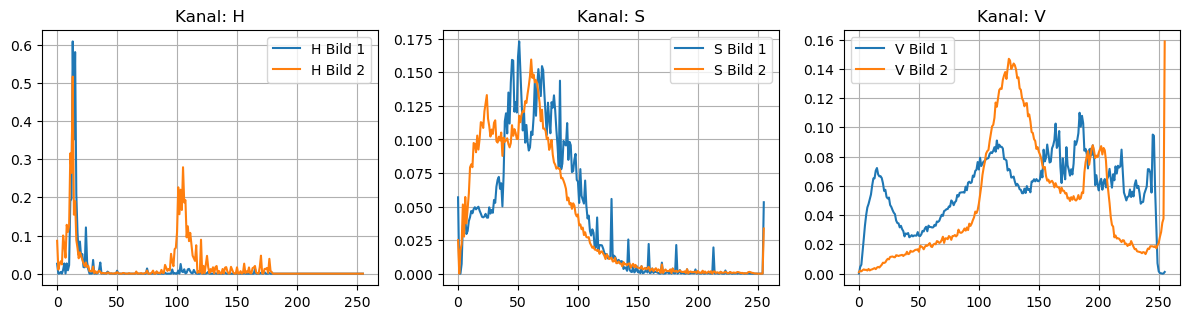

Correlation-Score: 0.6562919513371476


In [17]:
similarity_cor = color_histogram_similarity(bild1, bild2, color_space='HSV')
print("Correlation-Score:", similarity_cor)

Methode 2: Dominante Farben via K-Means

- Extrahieren der 3 häufigsten Farben pro Bild
- Vergleich der Farbzentren durch euklidische Distanz
- Ziel: eine kleinere Distanz bedeutet größere Farbähnlichkeit

In [18]:

def get_dominant_colors(img, k=3):
    '''
    img: BGR-Array
    '''
    pixels = img.reshape(-1, 3)            
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_         # array k×3 (BGR-colors)

def plot_color_palette(colors, title):
    '''
    colors: kx3-Array
    title: str
    '''
    plt.figure(figsize=(3, 1))
    for i, col in enumerate(colors):
        # change into [0,1] and RGB
        rgb = col[::-1] / 255.0
        plt.fill_between([i, i+1], 0, 1, color=rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def kmeans_color_distance(colors1, colors2):
    '''
    sort for stable comparison
    colors1, colors2: kx3-Array
    '''
    c1 = np.sort(colors1, axis=0)
    c2 = np.sort(colors2, axis=0)
    return np.linalg.norm(c1 - c2)


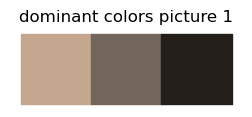

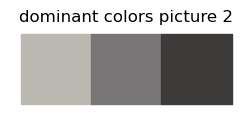

K-Means color distance: 73.1


In [19]:
cols1 = get_dominant_colors(bild1)
cols2 = get_dominant_colors(bild2)

plot_color_palette(cols1, "dominant colors picture 1")
plot_color_palette(cols2, "dominant colors picture 2")

dist = kmeans_color_distance(cols1, cols2)
print(f"K-Means color distance: {dist:.1f}")

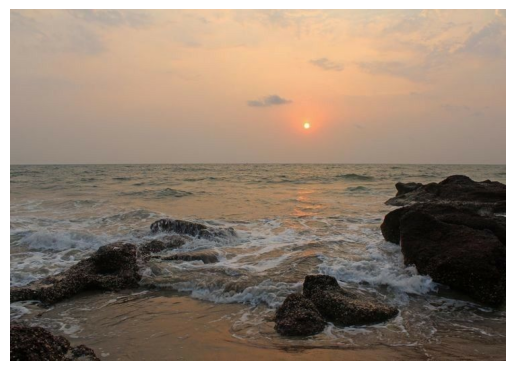

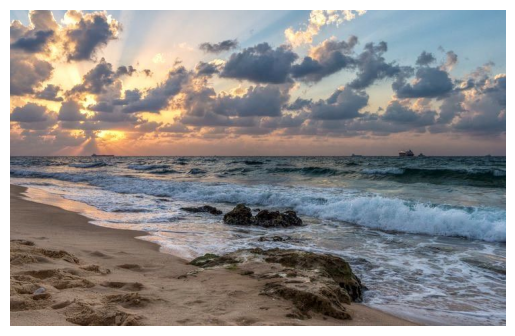

In [20]:
# Bilder anzeigen
bild1 = cv2.cvtColor(bild1, cv2.COLOR_BGR2RGB)
bild2 = cv2.cvtColor(bild2, cv2.COLOR_BGR2RGB)

plt.imshow(bild1)
plt.axis('off')
plt.show()

plt.imshow(bild2)
plt.axis('off')
plt.show()